In [61]:
#投資組合1

import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt

parser= lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
retData = pd.read_csv('retData1.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser,
                      usecols=['Date', 'SPY','EWJ','EWC','EWG','50','51'])



cumreturn=(1+retData).cumprod()-1
cumreturn.plot()
plt.title('Cumulative Return of 6 stocks(2016)')
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.3),
          ncol=5,fancybox=True,shadow=True)

retData=retData.dropna()
retData.corr()



,SPY,EWJ,EWC,EWG,50,51
SPY,1.000000,0.702562,0.750826,0.796367,0.021428,0.086329
EWJ,0.702562,1.000000,0.593888,0.649313,-0.009905,0.009740
EWC,0.750826,0.593888,1.000000,0.689132,0.101356,0.067558
EWG,0.796367,0.649313,0.689132,1.000000,0.062564,0.034219
50,0.021428,-0.009905,0.101356,0.062564,1.000000,0.467408
51,0.086329,0.009740,0.067558,0.034219,0.467408,1.000000


In [49]:
import portfolioopt as pfopt
import numpy as np

train_set=retData['2016-01-04':'2016-03-31']
test_set=retData['2016-04-01':'2016-12-30']
cov_mat=train_set.cov()
avg_rets = train_set.mean()
target_ret=0.0001
weights=pfopt.markowitz_portfolio(cov_mat,avg_rets,target_ret,allow_short=False)

weights



SPY    0.347323
EWJ    0.013773
EWC    0.000170
EWG    0.028406
50     0.525283
51     0.085044
dtype: float64

In [62]:
test_return=np.dot(test_set,np.matrix(weights).T)
test_return=pd.DataFrame(test_return,index=test_set.index)
test_cum_return=(1+test_return).cumprod()-1
test_cum_return.columns=['markowitz_portfolio']
test_cum_return



,markowitz_portfolio
Date,
2016-04-01,0.001414
2016-04-04,-0.004515
2016-04-05,0.000715
2016-04-06,0.004336
2016-04-07,-0.007070
2016-04-08,-0.018615
2016-04-11,-0.021910
2016-04-12,-0.012619
2016-04-13,-0.006465


In [63]:
from scipy import linalg
import numpy as np

def blacklitterment(returns,tau,P,Q):
    mu =returns.mean()
    sigma = returns.cov()
    pil=mu
    ts = tau*sigma
    Omega = np.dot(np.dot(P,ts),P.T)*np.eye(Q.shape[0])
    middle = linalg.inv(np.dot(np.dot(P,ts),P.T)+Omega)
    er = np.expand_dims(pil,axis=0).T+np.dot(np.dot(np.dot(ts,P.T),middle),(Q-np.expand_dims(np.dot(P,pil.T),axis=1)))
    posteriorSigma = sigma + ts-np.dot(ts.dot(P.T).dot(middle).dot(P),ts)
    
    return [er,posteriorSigma]
    
pick1 = np.array([1,-1,0,0,0,0])
q1 = np.array([0.0003])
pick2 = np.array([0,0,1,-1,0,0])
q2 = np.array([0.09])
pick3 = np.array([0,0,0,0,1,-1])
q3 = np.array([0.009])
P = np.array([pick1,pick2,pick3])
Q =np.array([q1,q2,q3])
P
Q

res = blacklitterment(retData,0.1,P,Q)
target_ret2=0.0001
cov_mat2=res[1]
avg_rets2=pd.Series(res[0][:,0],index=retData.columns)
weights2=pfopt.markowitz_portfolio(cov_mat2,avg_rets2,target_ret2,allow_short=False)
weights2



SPY    0.436488
EWJ    0.017709
EWC    0.072148
EWG    0.000091
50     0.404014
51     0.069549
dtype: float64

In [64]:
train_set=retData['2016-01-04':'2016-03-31']
test_set2=retData['2016-04-01':'2016-12-30']
test_return2=np.dot(test_set2,np.matrix(weights2).T)
test_return2=pd.DataFrame(test_return2,index=test_set.index)
test_cum_return2=(1+test_return2).cumprod()-1
test_cum_return2.columns=['blacklitterment_portfolio']
test_cum_return2



,blacklitterment_portfolio
Date,
2016-04-01,0.001896
2016-04-04,-0.004052
2016-04-05,-0.002044
2016-04-06,0.002983
2016-04-07,-0.008207
2016-04-08,-0.015360
2016-04-11,-0.017776
2016-04-12,-0.007491
2016-04-13,-0.000822


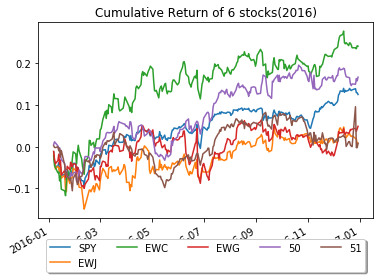

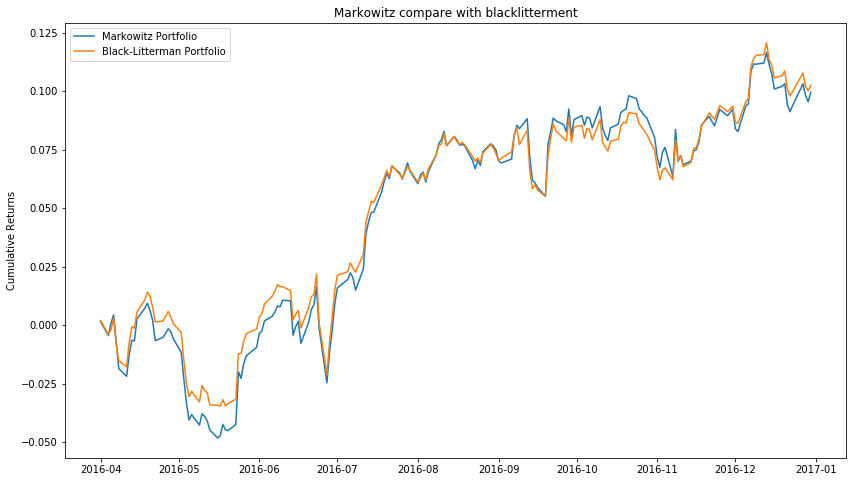

In [65]:
plt.figure(figsize=(14, 8))
plt.plot(test_cum_return.index,test_cum_return)
plt.plot(test_cum_return2.index,test_cum_return2)
plt.ylabel('Cumulative Returns')
plt.legend(['Markowitz Portfolio','Black-Litterman Portfolio'
            ],loc='upper left')
plt.title('Markowitz compare with blacklitterment')
plt.show()

In [80]:
#投資組合2


parser= lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
retData = pd.read_csv('retData2.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser,
                      usecols=['Date', 'SPY','EWU','EWA','EWH','50','52'])



cumreturn=(1+retData).cumprod()-1
cumreturn.plot()
plt.title('Cumulative Return of 6 stocks(2016)')
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.3),
          ncol=5,fancybox=True,shadow=True)

retData=retData.dropna()
retData.corr()




,SPY,EWU,EWA,EWH,50,52
SPY,1.000000,0.796066,0.774312,0.748389,0.021428,-0.013226
EWU,0.796066,1.000000,0.761335,0.707170,0.092265,-0.040977
EWA,0.774312,0.761335,1.000000,0.691765,0.063156,-0.016516
EWH,0.748389,0.707170,0.691765,1.000000,0.167666,-0.038209
50,0.021428,0.092265,0.063156,0.167666,1.000000,-0.053153
52,-0.013226,-0.040977,-0.016516,-0.038209,-0.053153,1.000000


In [82]:
train_set=retData['2016-01-06':'2016-03-31']
test_set=retData['2016-04-01':'2016-12-30']
cov_mat=train_set.cov()
avg_rets = train_set.mean()
target_ret=0.0001
weights=pfopt.markowitz_portfolio(cov_mat,avg_rets,target_ret,allow_short=False)

weights

SPY    0.258758
EWU    0.000339
EWA    0.000269
EWH    0.000200
50     0.484725
52     0.255709
dtype: float64

In [83]:
test_return=np.dot(test_set,np.matrix(weights).T)
test_return=pd.DataFrame(test_return,index=test_set.index)
test_cum_return=(1+test_return).cumprod()-1
test_cum_return.columns=['markowitz_portfolio']
test_cum_return


,markowitz_portfolio
Date,
2016-04-01,0.002129
2016-04-04,-0.000045
2016-04-05,0.004163
2016-04-06,0.006295
2016-04-07,-0.001494
2016-04-08,-0.010470
2016-04-11,-0.009372
2016-04-12,-0.003697
2016-04-13,0.002100


In [84]:
from scipy import linalg
import numpy as np

def blacklitterment(returns,tau,P,Q):
    mu =returns.mean()
    sigma = returns.cov()
    pil=mu
    ts = tau*sigma
    Omega = np.dot(np.dot(P,ts),P.T)*np.eye(Q.shape[0])
    middle = linalg.inv(np.dot(np.dot(P,ts),P.T)+Omega)
    er = np.expand_dims(pil,axis=0).T+np.dot(np.dot(np.dot(ts,P.T),middle),(Q-np.expand_dims(np.dot(P,pil.T),axis=1)))
    posteriorSigma = sigma + ts-np.dot(ts.dot(P.T).dot(middle).dot(P),ts)
    
    return [er,posteriorSigma]
    
pick1 = np.array([1,-1,0,0,0,0])
q1 = np.array([0.009])
pick2 = np.array([0,0,1,-1,0,0])
q2 = np.array([0.0006])
pick3 = np.array([0,0,0,0,1,1])
q3 = np.array([0.0009])
P = np.array([pick1,pick2,pick3])
Q =np.array([q1,q2,q3])
P
Q

res = blacklitterment(retData,0.1,P,Q)
target_ret2=0.0001
cov_mat2=res[1]
avg_rets2=pd.Series(res[0][:,0],index=retData.columns)
weights2=pfopt.markowitz_portfolio(cov_mat2,avg_rets2,target_ret2,allow_short=False)
weights2


SPY    0.283396
EWU    0.000001
EWA    0.000004
EWH    0.000007
50     0.398001
52     0.318591
dtype: float64

In [85]:
train_set=retData['2016-01-04':'2016-03-31']
test_set2=retData['2016-04-01':'2016-12-30']
test_return2=np.dot(test_set2,np.matrix(weights2).T)
test_return2=pd.DataFrame(test_return2,index=test_set.index)
test_cum_return2=(1+test_return2).cumprod()-1
test_cum_return2.columns=['blacklitterment_portfolio']
test_cum_return2


    


,blacklitterment_portfolio
Date,
2016-04-01,0.002234
2016-04-04,0.001112
2016-04-05,0.003401
2016-04-06,0.005773
2016-04-07,-0.001021
2016-04-08,-0.007441
2016-04-11,-0.005162
2016-04-12,-0.000408
2016-04-13,0.005614


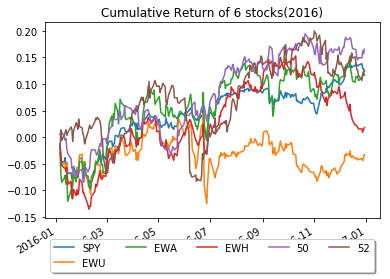

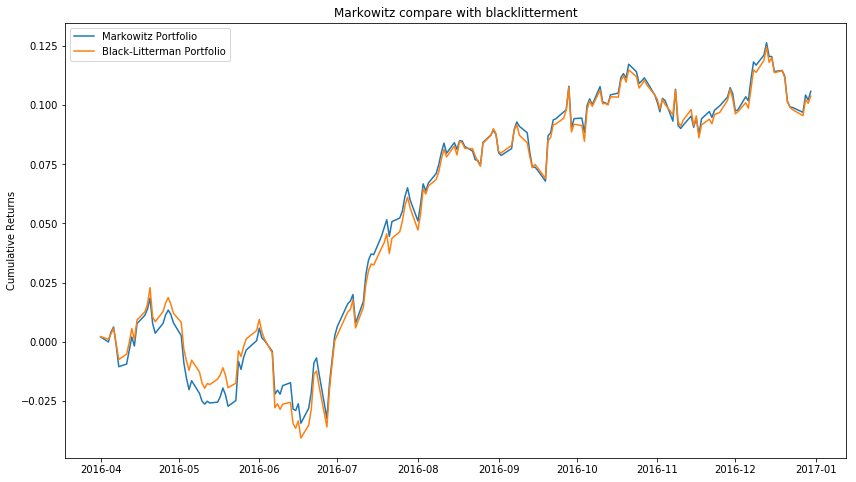

In [86]:
plt.figure(figsize=(14, 8))
plt.plot(test_cum_return.index,test_cum_return)
plt.plot(test_cum_return2.index,test_cum_return2)
plt.ylabel('Cumulative Returns')
plt.legend(['Markowitz Portfolio','Black-Litterman Portfolio'
            ],loc='upper left')
plt.title('Markowitz compare with blacklitterment')
plt.show()

In [87]:
#投資組合3


parser= lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
retData = pd.read_csv('retData3.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser,
                      usecols=['Date', 'SPY','EWP','EWL','EWW','50','53'])



cumreturn=(1+retData).cumprod()-1
cumreturn.plot()
plt.title('Cumulative Return of 6 stocks(2016)')
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.3),
          ncol=5,fancybox=True,shadow=True)

retData=retData.dropna()
retData.corr()



,SPY,EWP,EWL,EWW,50,53
SPY,1.000000,0.723364,0.790908,0.658333,0.021428,0.027142
EWP,0.723364,1.000000,0.820073,0.646352,0.068478,-0.025817
EWL,0.790908,0.820073,1.000000,0.627307,0.021882,0.017610
EWW,0.658333,0.646352,0.627307,1.000000,0.121930,-0.004643
50,0.021428,0.068478,0.021882,0.121930,1.000000,0.049372
53,0.027142,-0.025817,0.017610,-0.004643,0.049372,1.000000


In [88]:
train_set=retData['2016-01-06':'2016-03-31']
test_set=retData['2016-04-01':'2016-12-30']
cov_mat=train_set.cov()
avg_rets = train_set.mean()
target_ret=0.0001
weights=pfopt.markowitz_portfolio(cov_mat,avg_rets,target_ret,allow_short=False)

weights

SPY    0.075148
EWP    0.000374
EWL    0.248201
EWW    0.000635
50     0.346919
53     0.328724
dtype: float64

In [90]:
test_return=np.dot(test_set,np.matrix(weights).T)
test_return=pd.DataFrame(test_return,index=test_set.index)
test_cum_return=(1+test_return).cumprod()-1
test_cum_return.columns=['markowitz_portfolio']
test_cum_return

,markowitz_portfolio
Date,
2016-04-01,-0.001520
2016-04-04,-0.004072
2016-04-05,-0.003451
2016-04-06,0.007696
2016-04-07,0.001080
2016-04-08,-0.007748
2016-04-11,-0.017191
2016-04-12,-0.011822
2016-04-13,-0.006022


In [91]:
from scipy import linalg
import numpy as np

def blacklitterment(returns,tau,P,Q):
    mu =returns.mean()
    sigma = returns.cov()
    pil=mu
    ts = tau*sigma
    Omega = np.dot(np.dot(P,ts),P.T)*np.eye(Q.shape[0])
    middle = linalg.inv(np.dot(np.dot(P,ts),P.T)+Omega)
    er = np.expand_dims(pil,axis=0).T+np.dot(np.dot(np.dot(ts,P.T),middle),(Q-np.expand_dims(np.dot(P,pil.T),axis=1)))
    posteriorSigma = sigma + ts-np.dot(ts.dot(P.T).dot(middle).dot(P),ts)
    
    return [er,posteriorSigma]
    
pick1 = np.array([-1,1,0,0,0,0])
q1 = np.array([0.09])
pick2 = np.array([0,0,1,-1,0,0])
q2 = np.array([0.0009])
pick3 = np.array([0,0,0,0,1,-1])
q3 = np.array([0.0009])
P = np.array([pick1,pick2,pick3])
Q =np.array([q1,q2,q3])
P
Q

res = blacklitterment(retData,0.1,P,Q)
target_ret2=0.0001
cov_mat2=res[1]
avg_rets2=pd.Series(res[0][:,0],index=retData.columns)
weights2=pfopt.markowitz_portfolio(cov_mat2,avg_rets2,target_ret2,allow_short=False)
weights2


SPY    0.386612
EWP    0.000380
EWL    0.029542
EWW    0.000397
50     0.298554
53     0.284515
dtype: float64

In [92]:
train_set=retData['2016-01-04':'2016-03-31']
test_set2=retData['2016-04-01':'2016-12-30']
test_return2=np.dot(test_set2,np.matrix(weights2).T)
test_return2=pd.DataFrame(test_return2,index=test_set.index)
test_cum_return2=(1+test_return2).cumprod()-1
test_cum_return2.columns=['blacklitterment_portfolio']
test_cum_return2



,blacklitterment_portfolio
Date,
2016-04-01,0.001866
2016-04-04,-0.001758
2016-04-05,-0.002900
2016-04-06,0.006256
2016-04-07,-0.001338
2016-04-08,-0.010222
2016-04-11,-0.018075
2016-04-12,-0.012281
2016-04-13,-0.005468


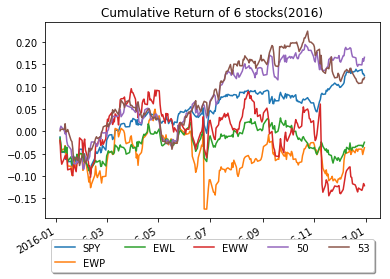

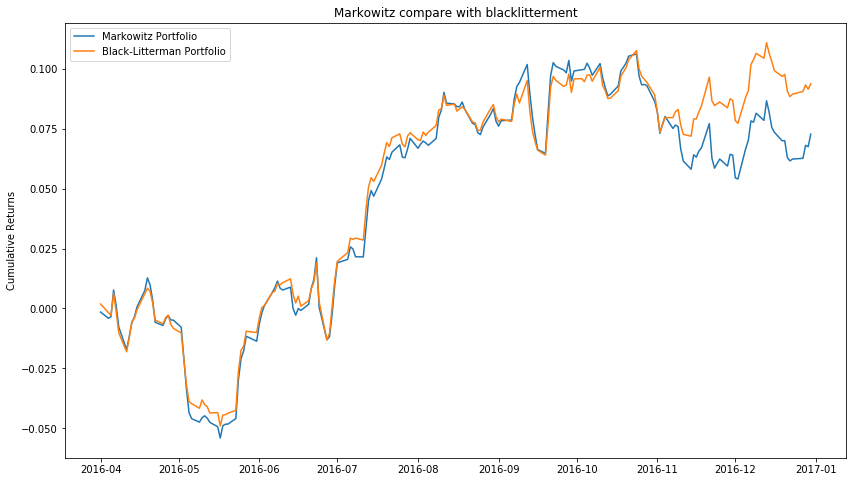

In [93]:
plt.figure(figsize=(14, 8))
plt.plot(test_cum_return.index,test_cum_return)
plt.plot(test_cum_return2.index,test_cum_return2)
plt.ylabel('Cumulative Returns')
plt.legend(['Markowitz Portfolio','Black-Litterman Portfolio'
            ],loc='upper left')
plt.title('Markowitz compare with blacklitterment')
plt.show()

In [104]:
#投資組合4


parser= lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
retData = pd.read_csv('retData4.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser,
                      usecols=['Date', 'SPY','EWI','EWS','EWD','50','54'])



cumreturn=(1+retData).cumprod()-1
cumreturn.plot()
plt.title('Cumulative Return of 6 stocks(2016)')
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.3),
          ncol=5,fancybox=True,shadow=True)

retData=retData.dropna()
retData.corr()


,SPY,EWI,EWS,EWD,50,54
SPY,1.000000,0.728535,0.708312,0.773690,0.027597,0.074913
EWI,0.728535,1.000000,0.649797,0.848207,0.060189,0.066955
EWS,0.708312,0.649797,1.000000,0.747767,0.147893,0.107985
EWD,0.773690,0.848207,0.747767,1.000000,0.066174,0.059571
50,0.027597,0.060189,0.147893,0.066174,1.000000,0.092140
54,0.074913,0.066955,0.107985,0.059571,0.092140,1.000000


In [105]:
train_set=retData['2016-01-06':'2016-03-31']
test_set=retData['2016-04-01':'2016-12-30']
cov_mat=train_set.cov()
avg_rets = train_set.mean()
target_ret=0.0001
weights=pfopt.markowitz_portfolio(cov_mat,avg_rets,target_ret,allow_short=False)

weights

SPY    0.307121
EWI    0.000063
EWS    0.000501
EWD    0.000551
50     0.448573
54     0.243190
dtype: float64

In [106]:
test_return=np.dot(test_set,np.matrix(weights).T)
test_return=pd.DataFrame(test_return,index=test_set.index)
test_cum_return=(1+test_return).cumprod()-1
test_cum_return.columns=['markowitz_portfolio']
test_cum_return

,markowitz_portfolio
Date,
2016-04-01,0.002984
2016-04-06,-0.000455
2016-04-07,-0.000342
2016-04-08,-0.000456
2016-04-11,0.003775
2016-04-12,0.007026
2016-04-13,-0.003958
2016-04-14,-0.012695
2016-04-15,-0.016316


In [108]:
from scipy import linalg
import numpy as np

def blacklitterment(returns,tau,P,Q):
    mu =returns.mean()
    sigma = returns.cov()
    pil=mu
    ts = tau*sigma
    Omega = np.dot(np.dot(P,ts),P.T)*np.eye(Q.shape[0])
    middle = linalg.inv(np.dot(np.dot(P,ts),P.T)+Omega)
    er = np.expand_dims(pil,axis=0).T+np.dot(np.dot(np.dot(ts,P.T),middle),(Q-np.expand_dims(np.dot(P,pil.T),axis=1)))
    posteriorSigma = sigma + ts-np.dot(ts.dot(P.T).dot(middle).dot(P),ts)
    
    return [er,posteriorSigma]
    
pick1 = np.array([1,-1,0,0,0,0])
q1 = np.array([0.009])
pick2 = np.array([0,0,1,-1,0,0])
q2 = np.array([0.0009])
pick3 = np.array([0,0,0,0,1,-1])
q3 = np.array([0.0009])
P = np.array([pick1,pick2,pick3])
Q =np.array([q1,q2,q3])
P
Q

res = blacklitterment(retData,0.1,P,Q)
target_ret2=0.0001
cov_mat2=res[1]
avg_rets2=pd.Series(res[0][:,0],index=retData.columns)
weights2=pfopt.markowitz_portfolio(cov_mat2,avg_rets2,target_ret2,allow_short=False)
weights2


SPY    0.320361
EWI    0.000001
EWS    0.000007
EWD    0.000004
50     0.462833
54     0.216794
dtype: float64

In [109]:
train_set=retData['2016-01-04':'2016-03-31']
test_set2=retData['2016-04-01':'2016-12-30']
test_return2=np.dot(test_set2,np.matrix(weights2).T)
test_return2=pd.DataFrame(test_return2,index=test_set.index)
test_cum_return2=(1+test_return2).cumprod()-1
test_cum_return2.columns=['blacklitterment_portfolio']
test_cum_return2

,blacklitterment_portfolio
Date,
2016-04-01,0.002846
2016-04-06,-0.000619
2016-04-07,-0.000153
2016-04-08,-0.000844
2016-04-11,0.003509
2016-04-12,0.006847
2016-04-13,-0.004229
2016-04-14,-0.013397
2016-04-15,-0.016987


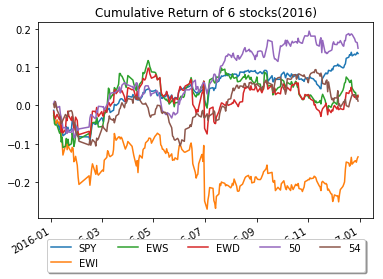

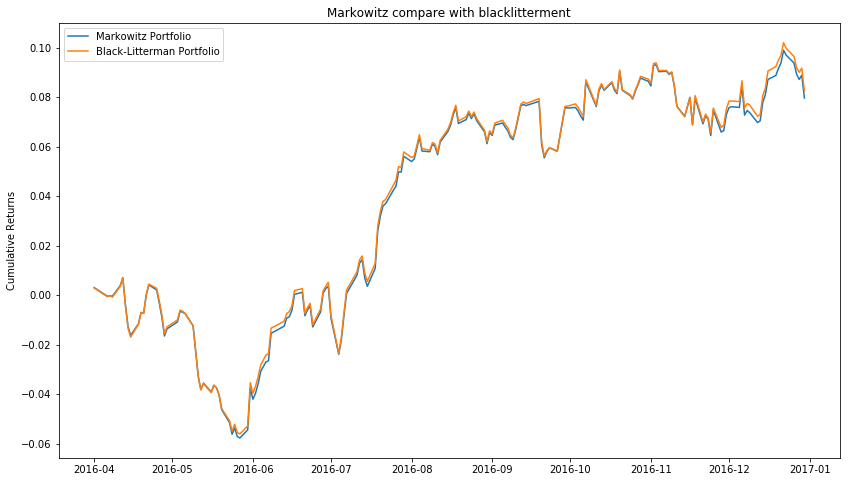

In [110]:
plt.figure(figsize=(14, 8))
plt.plot(test_cum_return.index,test_cum_return)
plt.plot(test_cum_return2.index,test_cum_return2)
plt.ylabel('Cumulative Returns')
plt.legend(['Markowitz Portfolio','Black-Litterman Portfolio'
            ],loc='upper left')
plt.title('Markowitz compare with blacklitterment')
plt.show()

In [111]:
#投資組合5


parser= lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
retData = pd.read_csv('retData5.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser,
                      usecols=['Date', 'SPY','EWM','EWO','EWN','50','55'])



cumreturn=(1+retData).cumprod()-1
cumreturn.plot()
plt.title('Cumulative Return of 6 stocks(2016)')
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.3),
          ncol=5,fancybox=True,shadow=True)

retData=retData.dropna()
retData.corr()

,SPY,EWM,EWO,EWN,50,55
SPY,1.000000,0.655657,0.704087,0.827110,0.021428,-0.001203
EWM,0.655657,1.000000,0.596301,0.677063,0.114902,-0.034877
EWO,0.704087,0.596301,1.000000,0.843493,0.114772,0.097384
EWN,0.827110,0.677063,0.843493,1.000000,0.073382,0.011222
50,0.021428,0.114902,0.114772,0.073382,1.000000,0.678590
55,-0.001203,-0.034877,0.097384,0.011222,0.678590,1.000000


In [112]:
train_set=retData['2016-01-06':'2016-03-31']
test_set=retData['2016-04-01':'2016-12-30']
cov_mat=train_set.cov()
avg_rets = train_set.mean()
target_ret=0.0001
weights=pfopt.markowitz_portfolio(cov_mat,avg_rets,target_ret,allow_short=False)

weights

SPY    0.388996
EWM    0.000629
EWO    0.000459
EWN    0.011160
50     0.569148
55     0.029608
dtype: float64

In [113]:
test_return=np.dot(test_set,np.matrix(weights).T)
test_return=pd.DataFrame(test_return,index=test_set.index)
test_cum_return=(1+test_return).cumprod()-1
test_cum_return.columns=['markowitz_portfolio']
test_cum_return

,markowitz_portfolio
Date,
2016-04-01,0.003036
2016-04-04,-0.002589
2016-04-05,0.002886
2016-04-06,0.006944
2016-04-07,-0.004879
2016-04-08,-0.017613
2016-04-11,-0.020972
2016-04-12,-0.012080
2016-04-13,-0.005780


In [114]:
from scipy import linalg
import numpy as np

def blacklitterment(returns,tau,P,Q):
    mu =returns.mean()
    sigma = returns.cov()
    pil=mu
    ts = tau*sigma
    Omega = np.dot(np.dot(P,ts),P.T)*np.eye(Q.shape[0])
    middle = linalg.inv(np.dot(np.dot(P,ts),P.T)+Omega)
    er = np.expand_dims(pil,axis=0).T+np.dot(np.dot(np.dot(ts,P.T),middle),(Q-np.expand_dims(np.dot(P,pil.T),axis=1)))
    posteriorSigma = sigma + ts-np.dot(ts.dot(P.T).dot(middle).dot(P),ts)
    
    return [er,posteriorSigma]
    
pick1 = np.array([1,-1,0,0,0,0])
q1 = np.array([0.009])
pick2 = np.array([0,0,1,-1,0,0])
q2 = np.array([0.0009])
pick3 = np.array([0,0,0,0,1,-1])
q3 = np.array([0.0009])
P = np.array([pick1,pick2,pick3])
Q =np.array([q1,q2,q3])
P
Q

res = blacklitterment(retData,0.1,P,Q)
target_ret2=0.0001
cov_mat2=res[1]
avg_rets2=pd.Series(res[0][:,0],index=retData.columns)
weights2=pfopt.markowitz_portfolio(cov_mat2,avg_rets2,target_ret2,allow_short=False)
weights2


SPY    0.514220
EWM    0.000223
EWO    0.000224
EWN    0.000199
50     0.185212
55     0.299923
dtype: float64

In [115]:
train_set=retData['2016-01-04':'2016-03-31']
test_set2=retData['2016-04-01':'2016-12-30']
test_return2=np.dot(test_set2,np.matrix(weights2).T)
test_return2=pd.DataFrame(test_return2,index=test_set.index)
test_cum_return2=(1+test_return2).cumprod()-1
test_cum_return2.columns=['blacklitterment_portfolio']
test_cum_return2

,blacklitterment_portfolio
Date,
2016-04-01,0.003635
2016-04-04,-0.002683
2016-04-05,-0.001979
2016-04-06,0.004639
2016-04-07,-0.006138
2016-04-08,-0.013875
2016-04-11,-0.018182
2016-04-12,-0.012706
2016-04-13,-0.005912


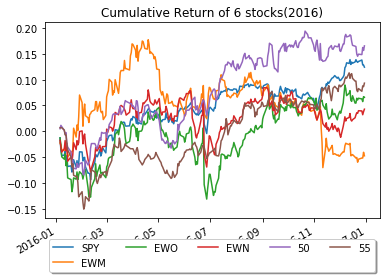

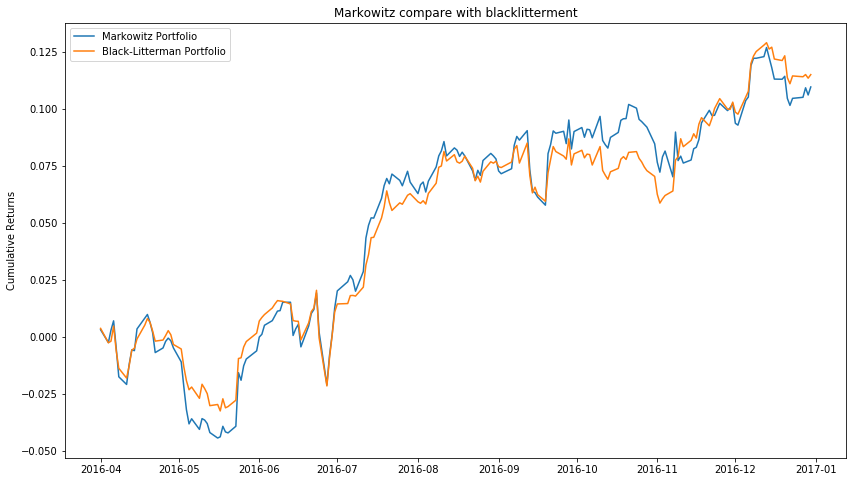

In [116]:
plt.figure(figsize=(14, 8))
plt.plot(test_cum_return.index,test_cum_return)
plt.plot(test_cum_return2.index,test_cum_return2)
plt.ylabel('Cumulative Returns')
plt.legend(['Markowitz Portfolio','Black-Litterman Portfolio'
            ],loc='upper left')
plt.title('Markowitz compare with blacklitterment')
plt.show()

In [139]:
#投資組合6


parser= lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
retData = pd.read_csv('retData6.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser,
                      usecols=['Date', 'SPY','EWK','XLF','DIA','50','56'])



cumreturn=(1+retData).cumprod()-1
cumreturn.plot()
plt.title('Cumulative Return of 6 stocks(2016)')
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.3),
          ncol=5,fancybox=True,shadow=True)

retData=retData.dropna()
retData.corr()

,SPY,EWK,XLF,DIA,50,56
SPY,1.000000,0.772264,0.482864,0.970858,0.021428,-0.036676
EWK,0.772264,1.000000,0.376144,0.723494,0.076916,0.026093
XLF,0.482864,0.376144,1.000000,0.492551,-0.020511,-0.009092
DIA,0.970858,0.723494,0.492551,1.000000,0.033753,-0.031450
50,0.021428,0.076916,-0.020511,0.033753,1.000000,0.721885
56,-0.036676,0.026093,-0.009092,-0.031450,0.721885,1.000000


In [140]:
train_set=retData['2016-01-06':'2016-03-31']
test_set=retData['2016-04-01':'2016-12-30']
cov_mat=train_set.cov()
avg_rets = train_set.mean()
target_ret=0.0001
weights=pfopt.markowitz_portfolio(cov_mat,avg_rets,target_ret,allow_short=False)

weights

SPY    0.018045
EWK    0.143648
XLF    0.000063
DIA    0.167664
50     0.000495
56     0.670085
dtype: float64

In [141]:
test_return=np.dot(test_set,np.matrix(weights).T)
test_return=pd.DataFrame(test_return,index=test_set.index)
test_cum_return=(1+test_return).cumprod()-1
test_cum_return.columns=['markowitz_portfolio']
test_cum_return

,markowitz_portfolio
Date,
2016-04-01,0.002094
2016-04-04,-0.004999
2016-04-05,-0.002229
2016-04-06,0.001647
2016-04-07,-0.006796
2016-04-08,-0.011027
2016-04-11,-0.012700
2016-04-12,-0.013065
2016-04-13,-0.010179


In [142]:
from scipy import linalg
import numpy as np

def blacklitterment(returns,tau,P,Q):
    mu =returns.mean()
    sigma = returns.cov()
    pil=mu
    ts = tau*sigma
    Omega = np.dot(np.dot(P,ts),P.T)*np.eye(Q.shape[0])
    middle = linalg.inv(np.dot(np.dot(P,ts),P.T)+Omega)
    er = np.expand_dims(pil,axis=0).T+np.dot(np.dot(np.dot(ts,P.T),middle),(Q-np.expand_dims(np.dot(P,pil.T),axis=1)))
    posteriorSigma = sigma + ts-np.dot(ts.dot(P.T).dot(middle).dot(P),ts)
    
    return [er,posteriorSigma]
    
pick1 = np.array([1,1,0,0,0,0])
q1 = np.array([0.009])
pick2 = np.array([0,0,1,-1,0,0])
q2 = np.array([0.009])
pick3 = np.array([0,0,0,0,1,-1])
q3 = np.array([0.009])
P = np.array([pick1,pick2,pick3])
Q =np.array([q1,q2,q3])
P
Q

res = blacklitterment(retData,0.1,P,Q)
target_ret2=0.0001
cov_mat2=res[1]
avg_rets2=pd.Series(res[0][:,0],index=retData.columns)
weights2=pfopt.markowitz_portfolio(cov_mat2,avg_rets2,target_ret2,allow_short=False)
weights2


SPY    0.029049
EWK    0.003729
XLF    0.001508
DIA    0.497725
50     0.084425
56     0.383564
dtype: float64

In [143]:
train_set=retData['2016-01-04':'2016-03-31']
test_set2=retData['2016-04-01':'2016-12-30']
test_return2=np.dot(test_set2,np.matrix(weights2).T)
test_return2=pd.DataFrame(test_return2,index=test_set.index)
test_cum_return2=(1+test_return2).cumprod()-1
test_cum_return2.columns=['blacklitterment_portfolio']
test_cum_return2

,blacklitterment_portfolio
Date,
2016-04-01,0.003498
2016-04-04,-0.002683
2016-04-05,-0.001726
2016-04-06,0.002523
2016-04-07,-0.006434
2016-04-08,-0.010701
2016-04-11,-0.012573
2016-04-12,-0.008257
2016-04-13,-0.002169


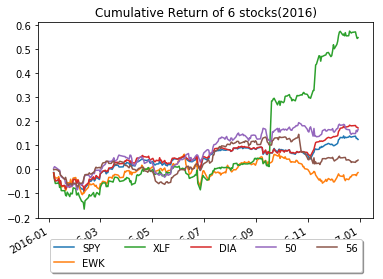

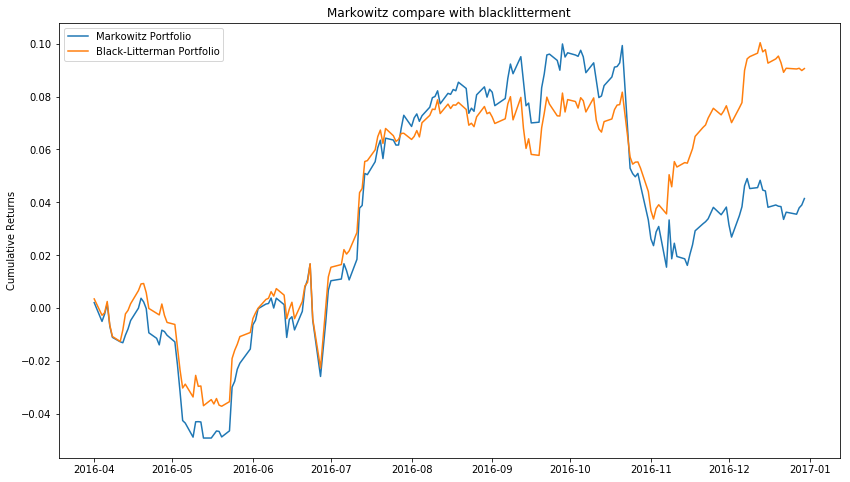

In [144]:
plt.figure(figsize=(14, 8))
plt.plot(test_cum_return.index,test_cum_return)
plt.plot(test_cum_return2.index,test_cum_return2)
plt.ylabel('Cumulative Returns')
plt.legend(['Markowitz Portfolio','Black-Litterman Portfolio'
            ],loc='upper left')
plt.title('Markowitz compare with blacklitterment')
plt.show()

In [145]:
#投資組合7


parser= lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
retData = pd.read_csv('retData7.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser,
                      usecols=['Date', 'XLI','XLE','XLF','XLK','50','57'])



cumreturn=(1+retData).cumprod()-1
cumreturn.plot()
plt.title('Cumulative Return of 6 stocks(2016)')
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.3),
          ncol=5,fancybox=True,shadow=True)

retData=retData.dropna()
retData.corr()

,XLI,XLE,XLF,XLK,50,57
XLI,1.000000,0.685824,0.506442,0.739857,0.023152,-0.033363
XLE,0.685824,1.000000,0.356512,0.569964,0.066893,0.009077
XLF,0.506442,0.356512,1.000000,0.355209,-0.020511,-0.004426
XLK,0.739857,0.569964,0.355209,1.000000,0.035497,-0.028388
50,0.023152,0.066893,-0.020511,0.035497,1.000000,0.021578
57,-0.033363,0.009077,-0.004426,-0.028388,0.021578,1.000000


In [146]:
train_set=retData['2016-01-06':'2016-03-31']
test_set=retData['2016-04-01':'2016-12-30']
cov_mat=train_set.cov()
avg_rets = train_set.mean()
target_ret=0.0001
weights=pfopt.markowitz_portfolio(cov_mat,avg_rets,target_ret,allow_short=False)

weights

XLI    0.146497
XLE    0.000151
XLF    0.000425
XLK    0.137522
50     0.467218
57     0.248186
dtype: float64

In [147]:
test_return=np.dot(test_set,np.matrix(weights).T)
test_return=pd.DataFrame(test_return,index=test_set.index)
test_cum_return=(1+test_return).cumprod()-1
test_cum_return.columns=['markowitz_portfolio']
test_cum_return

,markowitz_portfolio
Date,
2016-04-01,0.002101
2016-04-04,-0.004071
2016-04-05,-0.001811
2016-04-06,0.001451
2016-04-07,-0.003714
2016-04-08,-0.013273
2016-04-11,-0.012952
2016-04-12,-0.006480
2016-04-13,-0.000299


In [148]:
from scipy import linalg
import numpy as np

def blacklitterment(returns,tau,P,Q):
    mu =returns.mean()
    sigma = returns.cov()
    pil=mu
    ts = tau*sigma
    Omega = np.dot(np.dot(P,ts),P.T)*np.eye(Q.shape[0])
    middle = linalg.inv(np.dot(np.dot(P,ts),P.T)+Omega)
    er = np.expand_dims(pil,axis=0).T+np.dot(np.dot(np.dot(ts,P.T),middle),(Q-np.expand_dims(np.dot(P,pil.T),axis=1)))
    posteriorSigma = sigma + ts-np.dot(ts.dot(P.T).dot(middle).dot(P),ts)
    
    return [er,posteriorSigma]
    
pick1 = np.array([1,1,0,0,0,0])
q1 = np.array([0.009])
pick2 = np.array([0,0,1,-1,0,0])
q2 = np.array([0.009])
pick3 = np.array([0,0,0,0,1,-1])
q3 = np.array([0.009])
P = np.array([pick1,pick2,pick3])
Q =np.array([q1,q2,q3])
P
Q

res = blacklitterment(retData,0.1,P,Q)
target_ret2=0.0001
cov_mat2=res[1]
avg_rets2=pd.Series(res[0][:,0],index=retData.columns)
weights2=pfopt.markowitz_portfolio(cov_mat2,avg_rets2,target_ret2,allow_short=False)
weights2


XLI    0.254112
XLE    0.000283
XLF    0.005083
XLK    0.160762
50     0.330518
57     0.249242
dtype: float64

In [149]:
train_set=retData['2016-01-04':'2016-03-31']
test_set2=retData['2016-04-01':'2016-12-30']
test_return2=np.dot(test_set2,np.matrix(weights2).T)
test_return2=pd.DataFrame(test_return2,index=test_set.index)
test_cum_return2=(1+test_return2).cumprod()-1
test_cum_return2.columns=['blacklitterment_portfolio']
test_cum_return2

,blacklitterment_portfolio
Date,
2016-04-01,0.002715
2016-04-04,-0.003837
2016-04-05,-0.004774
2016-04-06,-0.000631
2016-04-07,-0.005641
2016-04-08,-0.011518
2016-04-11,-0.010649
2016-04-12,-0.004621
2016-04-13,0.002958


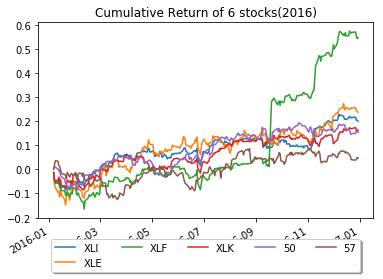

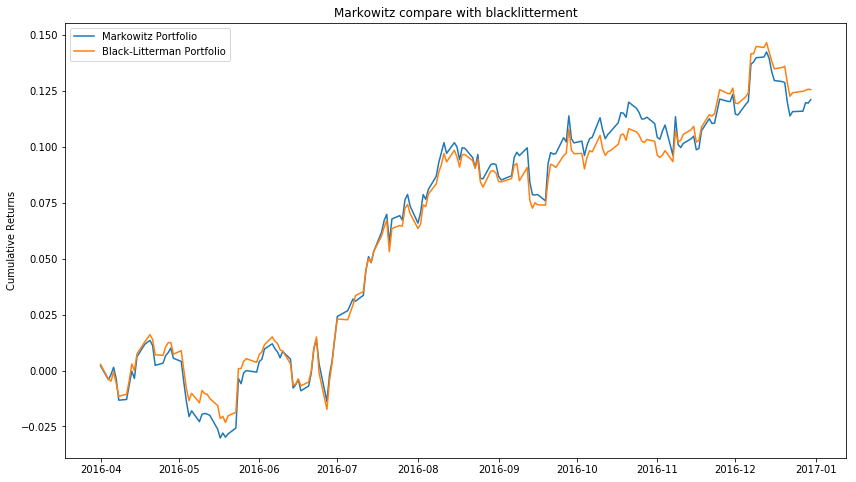

In [150]:
plt.figure(figsize=(14, 8))
plt.plot(test_cum_return.index,test_cum_return)
plt.plot(test_cum_return2.index,test_cum_return2)
plt.ylabel('Cumulative Returns')
plt.legend(['Markowitz Portfolio','Black-Litterman Portfolio'
            ],loc='upper left')
plt.title('Markowitz compare with blacklitterment')
plt.show()

In [151]:
#投資組合8 比較消費與非消費類股、羅素中型大型股


parser= lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
retData = pd.read_csv('retData8.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser,
                      usecols=['Date', 'XLY','XLP','IWM','IWB','50','59'])



cumreturn=(1+retData).cumprod()-1
cumreturn.plot()
plt.title('Cumulative Return of 6 stocks(2016)')
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.3),
          ncol=5,fancybox=True,shadow=True)

retData=retData.dropna()
retData.corr()

,XLY,XLP,IWM,IWB,50,59
XLY,1.000000,0.616407,0.812703,0.178708,0.018973,0.000618
XLP,0.616407,1.000000,0.460543,0.114952,-0.011983,0.036197
IWM,0.812703,0.460543,1.000000,0.276802,0.014348,0.026315
IWB,0.178708,0.114952,0.276802,1.000000,0.065698,0.001299
50,0.018973,-0.011983,0.014348,0.065698,1.000000,-0.027518
59,0.000618,0.036197,0.026315,0.001299,-0.027518,1.000000


In [152]:
train_set=retData['2016-01-06':'2016-03-31']
test_set=retData['2016-04-01':'2016-12-30']
cov_mat=train_set.cov()
avg_rets = train_set.mean()
target_ret=0.0001
weights=pfopt.markowitz_portfolio(cov_mat,avg_rets,target_ret,allow_short=False)

weights

XLY    0.001040
XLP    0.375763
IWM    0.001628
IWB    0.186007
50     0.226032
59     0.209530
dtype: float64

In [153]:
test_return=np.dot(test_set,np.matrix(weights).T)
test_return=pd.DataFrame(test_return,index=test_set.index)
test_cum_return=(1+test_return).cumprod()-1
test_cum_return.columns=['markowitz_portfolio']
test_cum_return

,markowitz_portfolio
Date,
2016-04-01,0.003269
2016-04-04,0.002467
2016-04-05,0.001794
2016-04-06,0.004900
2016-04-07,0.002846
2016-04-08,-0.002474
2016-04-11,-0.008504
2016-04-12,-0.008593
2016-04-13,-0.010572


In [154]:
from scipy import linalg
import numpy as np

def blacklitterment(returns,tau,P,Q):
    mu =returns.mean()
    sigma = returns.cov()
    pil=mu
    ts = tau*sigma
    Omega = np.dot(np.dot(P,ts),P.T)*np.eye(Q.shape[0])
    middle = linalg.inv(np.dot(np.dot(P,ts),P.T)+Omega)
    er = np.expand_dims(pil,axis=0).T+np.dot(np.dot(np.dot(ts,P.T),middle),(Q-np.expand_dims(np.dot(P,pil.T),axis=1)))
    posteriorSigma = sigma + ts-np.dot(ts.dot(P.T).dot(middle).dot(P),ts)
    
    return [er,posteriorSigma]
    
pick1 = np.array([1,1,0,0,0,0])
q1 = np.array([0.009])
pick2 = np.array([0,0,1,-1,0,0])
q2 = np.array([0.009])
pick3 = np.array([0,0,0,0,1,-1])
q3 = np.array([0.009])
P = np.array([pick1,pick2,pick3])
Q =np.array([q1,q2,q3])
P
Q

res = blacklitterment(retData,0.1,P,Q)
target_ret2=0.0001
cov_mat2=res[1]
avg_rets2=pd.Series(res[0][:,0],index=retData.columns)
weights2=pfopt.markowitz_portfolio(cov_mat2,avg_rets2,target_ret2,allow_short=False)
weights2


XLY    0.064068
XLP    0.313777
IWM    0.002489
IWB    0.237436
50     0.226552
59     0.155678
dtype: float64

In [155]:
train_set=retData['2016-01-04':'2016-03-31']
test_set2=retData['2016-04-01':'2016-12-30']
test_return2=np.dot(test_set2,np.matrix(weights2).T)
test_return2=pd.DataFrame(test_return2,index=test_set.index)
test_cum_return2=(1+test_return2).cumprod()-1
test_cum_return2.columns=['blacklitterment_portfolio']
test_cum_return2

,blacklitterment_portfolio
Date,
2016-04-01,0.002976
2016-04-04,0.002054
2016-04-05,0.001388
2016-04-06,0.003546
2016-04-07,0.001313
2016-04-08,-0.005102
2016-04-11,-0.010027
2016-04-12,-0.009034
2016-04-13,-0.008726


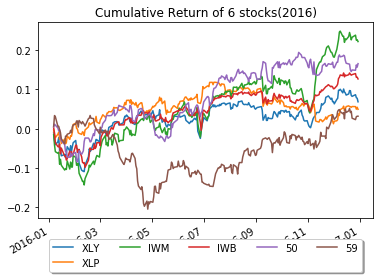

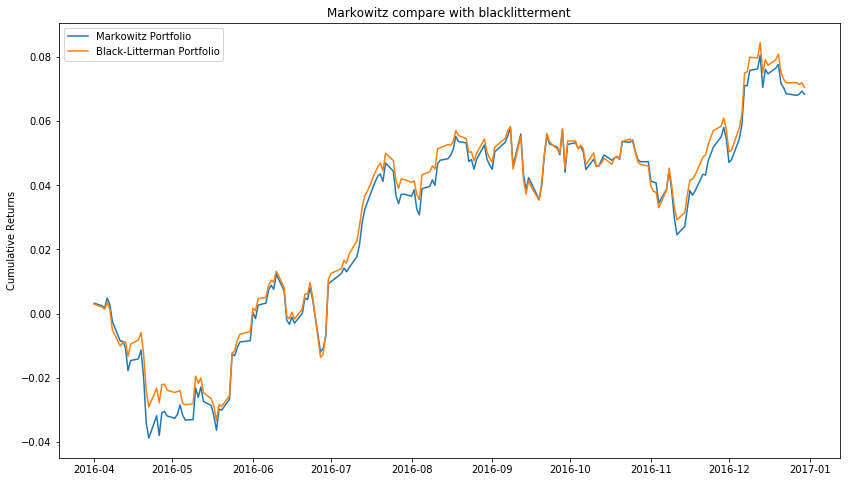

In [156]:
plt.figure(figsize=(14, 8))
plt.plot(test_cum_return.index,test_cum_return)
plt.plot(test_cum_return2.index,test_cum_return2)
plt.ylabel('Cumulative Returns')
plt.legend(['Markowitz Portfolio','Black-Litterman Portfolio'
            ],loc='upper left')
plt.title('Markowitz compare with blacklitterment')
plt.show()